In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd()))
print(project_root)
print("Current directory:", os.getcwd())

/public/home/CS182/qiyt2023-cs182/B4PPI-main
Current directory: /public/home/CS182/qiyt2023-cs182/B4PPI-main


In [3]:
embeddings = pd.read_pickle('./data/embeddings_merged2.pkl')
print(len(embeddings))

12026


In [ ]:
# embeddings = pd.read_pickle('./data/embeddings_merged.pkl')
# display(embeddings)

{'P20749': tensor([[[-0.0029,  0.0029,  0.0008,  ...,  0.0024, -0.0097, -0.0154],
          [ 0.0006,  0.0052,  0.0712,  ...,  0.0262, -0.0188,  0.0046],
          [-0.0030,  0.0255,  0.0100,  ..., -0.0067, -0.0266, -0.0098],
          ...,
          [-0.0097,  0.0314,  0.0150,  ..., -0.0167, -0.0470, -0.0096],
          [-0.0030,  0.0558, -0.0251,  ..., -0.0079, -0.0583, -0.0125],
          [-0.0033,  0.0351,  0.0090,  ..., -0.0080, -0.0495, -0.0266]]],
        dtype=torch.float16),
 'Q6UXS0': tensor([[[ 0.0016,  0.0038,  0.0080,  ...,  0.0023, -0.0062, -0.0087],
          [ 0.0056,  0.0193,  0.0495,  ...,  0.0047, -0.0280,  0.0072],
          [ 0.0098,  0.0203, -0.0313,  ..., -0.0404, -0.0653, -0.0015],
          ...,
          [-0.0481,  0.0276, -0.0117,  ..., -0.0320, -0.0212, -0.0041],
          [-0.0406, -0.0352, -0.0264,  ..., -0.0467, -0.0309,  0.0159],
          [-0.0224,  0.0247, -0.0029,  ..., -0.0104, -0.0474, -0.0283]]],
        dtype=torch.float16),
 'Q14241': tensor([[[ 

In [4]:
print(embeddings['P20749'].shape)

torch.Size([456, 960])


In [5]:
print(embeddings['Q8IY31'].shape)

torch.Size([134, 960])


In [6]:
print(embeddings['Q5BJH2'].shape)

torch.Size([167, 960])


In [7]:
columns_to_use = ['uniprotID_A', 'uniprotID_B', 'isInteraction']
train_data = pd.read_csv('./data/full_dataset/train_data.csv', usecols=columns_to_use)
print(train_data.head())

  uniprotID_A uniprotID_B  isInteraction
0      O43759      P59991              0
1      P54646      Q13671              0
2      O15344      Q9H9B1              0
3      O14964      Q9NQM4              0
4      Q5VYS8      Q9NZL9              0


In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/public/home/CS182/qiyt2023-cs182/.conda/envs/cs182_esm/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [9]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [10]:
np.random.seed(42)

In [11]:
train_embA = []
train_embB = []
train_y = []
for _, row in train_data.iterrows():
    a_id = row['uniprotID_A']
    b_id = row['uniprotID_B']
    label = row['isInteraction']

    if a_id in embeddings and b_id in embeddings:
        emb_a = embeddings[a_id][0]
        emb_b = embeddings[b_id][0]    #use cls token
        if emb_a.shape != emb_b.shape:
            print(f"Pooled shape mismatch: {a_id} {b_id} -> {emb_a.shape}, {emb_b.shape}")
            continue
        train_embA.append(emb_a)
        train_embB.append(emb_b)
        train_y.append(label)
    else:
        if a_id not in embeddings:
            print(f"Missing embedding for {a_id}")
        if b_id not in embeddings:
            print(f"Missing embedding for {b_id}")
train_embA = np.stack(train_embA)
train_embB = np.stack(train_embB)
train_y = np.array(train_y)
print(train_embA.shape)
print(train_embB.shape)
print(train_y.shape)

(85329, 960)
(85329, 960)
(85329,)


In [ ]:
# def mean_pool(embedding):
#     result = embedding.mean(dim=0).numpy()
#     #print(f"Mean pooled shape: {result.shape}")
#     return result

# train_embA = []
# train_embB = []
# train_y = []
# for _, row in train_data.iterrows():
#     a_id = row['uniprotID_A']
#     b_id = row['uniprotID_B']
#     label = row['isInteraction']

#     if a_id in embeddings and b_id in embeddings:
#         emb_a = mean_pool(embeddings[a_id][0])
#         emb_b = mean_pool(embeddings[b_id][0])
#         if emb_a.shape != emb_b.shape:
#             print(f"Pooled shape mismatch: {a_id} {b_id} -> {emb_a.shape}, {emb_b.shape}")
#             continue
#         train_embA.append(emb_a)
#         train_embB.append(emb_b)
#         train_y.append(label)
#     else:
#         if a_id not in embeddings:
#             print(f"Missing embedding for {a_id}")
#         if b_id not in embeddings:
#             print(f"Missing embedding for {b_id}")
# train_embA = np.stack(train_embA)
# train_embB = np.stack(train_embB)
# train_y = np.array(train_y)

Missing embedding for Q9NWN3
Missing embedding for Q5T4B2
Missing embedding for Q15041
Missing embedding for Q5W5X9
Missing embedding for Q9BUN5
Missing embedding for P48165
Missing embedding for Q9H0W9
Missing embedding for Q15311
Missing embedding for Q9BTY2
Missing embedding for P56851
Missing embedding for Q96CN5
Missing embedding for Q15041
Missing embedding for O43820
Missing embedding for Q8WVP5
Missing embedding for P23760
Missing embedding for Q8IXX5
Missing embedding for Q9GZZ9
Missing embedding for O00154
Missing embedding for Q04323
Missing embedding for Q9UL15
Missing embedding for O75208
Missing embedding for O43809
Missing embedding for Q7Z3Z0
Missing embedding for Q9GZX9
Missing embedding for O75460
Missing embedding for O14735
Missing embedding for Q15910
Missing embedding for Q7L273
Missing embedding for Q8IZ57
Missing embedding for Q16637
Missing embedding for P50213
Missing embedding for Q9NRQ2
Missing embedding for P15941
Missing embedding for Q8NHS1
Missing embedd

In [12]:
validation_data = pd.read_csv('./data/full_dataset/validation_data.csv', usecols=columns_to_use)

In [13]:
val_embA = []
val_embB = []
val_y = []

for _, row in validation_data.iterrows():
    a_id = row['uniprotID_A']
    b_id = row['uniprotID_B']
    label = row['isInteraction']

    if a_id in embeddings and b_id in embeddings:
        emb_a = embeddings[a_id][0]
        emb_b = embeddings[b_id][0]
        if emb_a.shape != emb_b.shape:
            print(f"Pooled shape mismatch: {a_id} {b_id} -> {emb_a.shape}, {emb_b.shape}")
            continue
        val_embA.append(emb_a)
        val_embB.append(emb_b)
        val_y.append(label)
    else:
        if a_id not in embeddings:
            print(f"Missing embedding for {a_id}")
        if b_id not in embeddings:
            print(f"Missing embedding for {b_id}")

val_embA = np.stack(val_embA)
val_embB = np.stack(val_embB)
val_y = np.array(val_y)
print(val_embA.shape)
print(val_embB.shape)
print(val_y.shape)

(21333, 960)
(21333, 960)
(21333,)


In [14]:
test1_data = pd.read_csv('./data/full_dataset/test1_data.csv', usecols=columns_to_use)

In [15]:
test1_embA = []
test1_embB = []
test1_y = []

for _, row in test1_data.iterrows():
    a_id = row['uniprotID_A']
    b_id = row['uniprotID_B']
    label = row['isInteraction']

    if a_id in embeddings and b_id in embeddings:
        emb_a = embeddings[a_id][0]
        emb_b = embeddings[b_id][0]
        if emb_a.shape != emb_b.shape:
            print(f"Pooled shape mismatch: {a_id} {b_id} -> {emb_a.shape}, {emb_b.shape}")
            continue
        test1_embA.append(emb_a)
        test1_embB.append(emb_b)
        test1_y.append(label)
    else:
        if a_id not in embeddings:
            print(f"Missing embedding for {a_id}")
        if b_id not in embeddings:
            print(f"Missing embedding for {b_id}")

test1_embA = np.stack(test1_embA)
test1_embB = np.stack(test1_embB)
test1_y = np.array(test1_y)
print(test1_embA.shape)
print(test1_embB.shape)
print(test1_y.shape)

(24898, 960)
(24898, 960)
(24898,)


In [16]:
test2_data = pd.read_csv('./data/full_dataset/test2_data.csv', usecols=columns_to_use)

In [17]:
test2_embA = []
test2_embB = []
test2_y = []

for _, row in test2_data.iterrows():
    a_id = row['uniprotID_A']
    b_id = row['uniprotID_B']
    label = row['isInteraction']

    if a_id in embeddings and b_id in embeddings:
        emb_a = embeddings[a_id][0]
        emb_b = embeddings[b_id][0]
        if emb_a.shape != emb_b.shape:
            print(f"Pooled shape mismatch: {a_id} {b_id} -> {emb_a.shape}, {emb_b.shape}")
            continue
        test2_embA.append(emb_a)
        test2_embB.append(emb_b)
        test2_y.append(label)
    else:
        if a_id not in embeddings:
            print(f"Missing embedding for {a_id}")
        if b_id not in embeddings:
            print(f"Missing embedding for {b_id}")

test2_embA = np.stack(test2_embA)
test2_embB = np.stack(test2_embB)
test2_y = np.array(test2_y)
print(test2_embA.shape)
print(test2_embB.shape)
print(test2_y.shape)

(136939, 960)
(136939, 960)
(136939,)


In [18]:

def create_features(embA, embB, method='all'):
    print(embA.shape)
    if method == 'all':
        return np.concatenate([embA, embB, np.abs(embA - embB), embA * embB], axis=1)
    elif method == 'add_sub':
        return np.concatenate([embA + embB, embA - embB], axis=1)
    elif method == 'mul_only':
        return embA * embB
    elif method == 'reduced':
        return np.concatenate([np.abs(embA - embB), embA * embB], axis=1)
    else:
        raise ValueError(f"Unknown method: {method}")




In [ ]:
best_xgb_params = {
    'colsample_bytree': 0.8997767208035865,
    'learning_rate': 0.04436313425678925,
    'max_depth': 7,
    'min_child_weight': 7,
    'n_estimators': 140,
    'subsample': 0.8585155755799185,
    'eval_metric': 'logloss'
}

In [19]:
methods = ['reduced']#, 'add_sub', 'mul_only'
best_score = 0
best_model = None
best_method = None
search_space = {
    'xgb__n_estimators': Integer(50, 150),
    'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'xgb__max_depth': Integer(3, 10),
    'xgb__min_child_weight': Integer(1, 10),
    'xgb__subsample': Real(0.5, 1.0),
    'xgb__colsample_bytree': Real(0.5, 1.0),
}

results = {}

In [ ]:
# xgb_params = {
#     'n_estimators': 80,          # 树的数量
#     'learning_rate': 0.05,       # 学习率较小，更稳健
#     'max_depth': 4,              # 树深度，防止过拟合
#     'min_child_weight': 5,       # 控制每棵树的复杂度
#     'subsample': 0.8,            # 训练样本采样比例
#     'colsample_bytree': 0.8,     # 特征采样比例
#     'tree_method': 'hist',       # 使用高效的直方图方法
#     'random_state': 42,
#     'device': 'cuda'
# }

In [20]:
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    precision_score, recall_score, average_precision_score,
    roc_curve, precision_recall_curve
)

In [21]:
for method in methods:#method = reduced
    X_train = create_features(train_embA, train_embB, method=method)
    X_val = create_features(val_embA, val_embB, method=method)
    X_test1 = create_features(test1_embA, test1_embB, method=method)
    X_test2 = create_features(test2_embA, test2_embB, method=method)

    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"train_y shape: {train_y.shape}")
    print(f"val_y shape: {val_y.shape}")

    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBClassifier(
        # use_label_encoder=False,
        eval_metric='logloss',
        # device='cuda'
    ))
    ])


    # 贝叶斯搜索
    search = BayesSearchCV(
        pipe,
        search_space,
        n_iter=10,
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    # 拟合模型
    search.fit(X_train, train_y)
    val_preds = search.predict(X_val)
    val_acc = accuracy_score(val_y, val_preds)

    results[method] = {
        'accuracy': val_acc,
        'best_params': search.best_params_,
        'model': search.best_estimator_
    }

    if val_acc > best_score:
        best_score = val_acc
        best_model = search.best_estimator_
        best_method = method

results_summary = {
    'best_method': best_method,
    'best_score': best_score,
    'best_params': results[best_method]['best_params']
}
print(results_summary)

(85329, 960)
(21333, 960)
(24898, 960)
(136939, 960)
X_train shape: (85329, 1920)
X_val shape: (21333, 1920)
train_y shape: (85329,)
val_y shape: (21333,)


/public/home/CS182/qiyt2023-cs182/.conda/envs/cs182_esm/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/public/home/CS182/qiyt2023-cs182/.conda/envs/cs182_esm/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
No

{'best_method': 'reduced', 'best_score': 0.6106501664088502, 'best_params': OrderedDict([('xgb__colsample_bytree', 0.8997767208035865), ('xgb__learning_rate', 0.04436313425678925), ('xgb__max_depth', 7), ('xgb__min_child_weight', 7), ('xgb__n_estimators', 140), ('xgb__subsample', 0.8585155755799185)])}


Test1 Accuracy: 0.5923367338742067
Test1 AUC: 0.6350979197309939
Test1 AUPRC: 0.6343957807169922
Test1 F1 Score: 0.5849349799623783
Test1 Precision: 0.5957517700957934
Test1 Recall: 0.5745039762229898


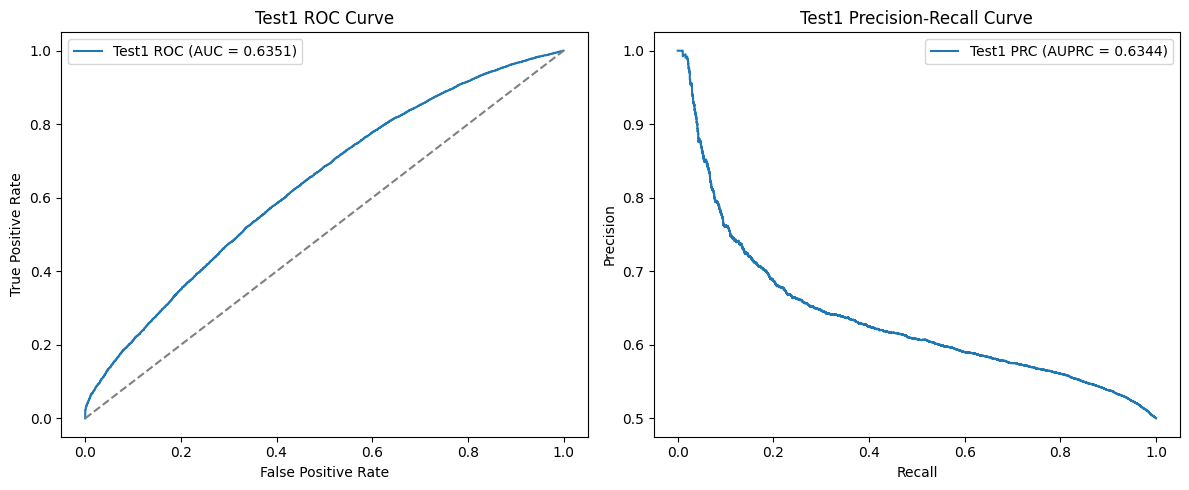

Test2 Accuracy: 0.6092639788518975
Test2 AUC: 0.6380049411140388
Test2 AUPRC: 0.1735967291888603
Test2 F1 Score: 0.21131141016759283
Test2 Precision: 0.12940029606094522
Test2 Recall: 0.5757892200176721


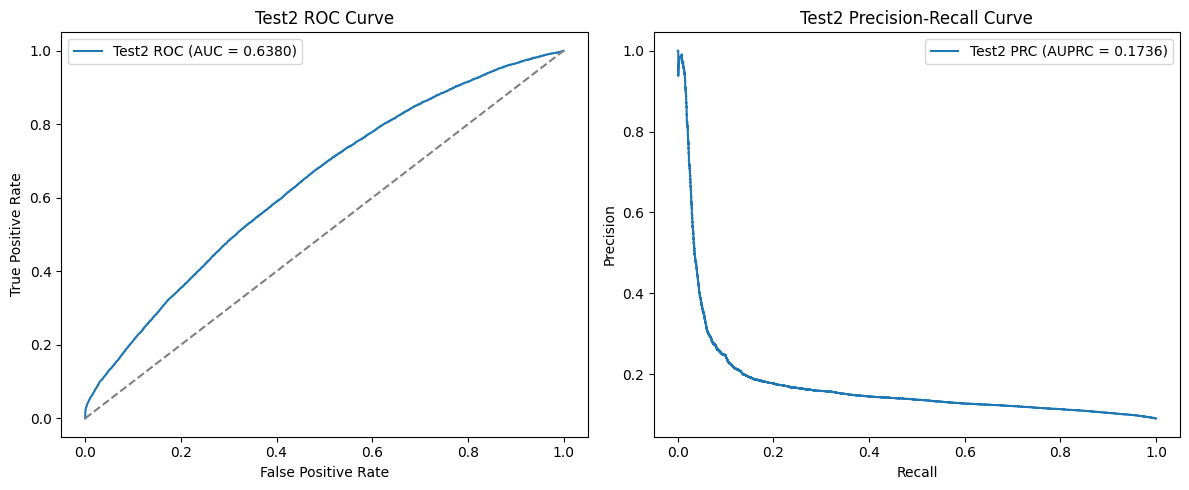

In [22]:
# 使用 best_model 进行测试
def evaluate_and_plot(X, y_true, name="Test"):
    y_pred = best_model.predict(X)
    y_prob = best_model.predict_proba(X)[:, 1]  # positive class probability

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auprc = average_precision_score(y_true, y_prob)

    print(f"{name} Accuracy:", acc)
    print(f"{name} AUC:", auc)
    print(f"{name} AUPRC:", auprc)
    print(f"{name} F1 Score:", f1)
    print(f"{name} Precision:", prec)
    print(f"{name} Recall:", rec)

    # Plot ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{name} ROC (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} ROC Curve")
    plt.legend()

    # Plot Precision-Recall
    precs, recalls, _ = precision_recall_curve(y_true, y_prob)
    plt.subplot(1, 2, 2)
    plt.plot(recalls, precs, label=f'{name} PRC (AUPRC = {auprc:.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 测试集评估
evaluate_and_plot(X_test1, test1_y, name="Test1")
evaluate_and_plot(X_test2, test2_y, name="Test2")

In [ ]:
# for method in methods:
#     # 组合特征
#     X_train = create_features(train_embA, train_embB, method=method)
#     X_val = create_features(val_embA, val_embB, method=method)

#     # 管道包含标准化和XGBoost分类器
#     pipe = Pipeline([
#         ('scaler', StandardScaler()),
#         ('xgb', xgb.XGBClassifier(**xgb_params))
#     ])

#     # # 贝叶斯搜索
#     # search = BayesSearchCV(
#     #     pipe,
#     #     search_space,
#     #     n_iter=20,
#     #     cv=3,
#     #     n_jobs=1,
#     #     random_state=42,
#     #     verbose=0
#     # )
#     print(f"X_train shape: {X_train.shape}")
#     print(f"X_val shape: {X_val.shape}")
#     print(f"train_y shape: {train_y.shape}")
#     print(f"val_y shape: {val_y.shape}")
#     # 拟合模型
#     # search.fit(X_train, train_y)
#     pipe.fit(X_train, train_y)
#     val_preds = pipe.predict(X_val)
#     val_acc = accuracy_score(val_y, val_preds)
#     print(f"Validation Accuracy ({method}):", val_acc)
#     # results[method] = {
#     #     'accuracy': val_acc,
#     #     'best_params': pipe.best_params_,
#     #     'model': pipe.best_estimator_
#     # }

#     if val_acc > best_score:
#         best_score = val_acc
#         #best_model = pipe.best_estimator_
#         best_method = method

# results_summary = {
#     'best_method': best_method,
#     'best_score': best_score,
#     'best_params': results[best_method]['best_params']
# }

NameError: name 'methods' is not defined

In [24]:
test1_preds = pipe.predict(X_test1)
test1_acc = accuracy_score(test1_y, test1_preds)
test1_auc = roc_auc_score(test1_y, test1_preds)
test1_f1 = f1_score(test1_y, test1_preds)
test1_precision = precision_score(test1_y, test1_preds)
test1_recall = recall_score(test1_y, test1_preds)
print(f"Test1 Accuracy):", test1_acc)
print(f"Test1 AUC):", test1_auc)
print(f"Test1 F1 Score):", test1_f1)
print(f"Test1 Precision):", test1_precision)
print(f"Test1 Recall):", test1_recall)

Test1 Accuracy): 0.5994950911640954
Test1 AUC): 0.5975879317827977
Test1 F1 Score): 0.6262890645448359
Test1 Precision): 0.6312790206838328
Test1 Recall): 0.6213773761296354


In [25]:
test2_preds = pipe.predict(X_test2)
test2_acc = accuracy_score(test2_y, test2_preds)
test2_auc = roc_auc_score(test2_y, test2_preds)
test2_f1 = f1_score(test2_y, test2_preds)
test2_precision = precision_score(test2_y, test2_preds)
test2_recall = recall_score(test2_y, test2_preds)
print(f"Test2 Accuracy):", test2_acc)
print(f"Test2 AUC):", test2_auc)
print(f"Test2 F1 Score):", test2_f1)
print(f"Test2 Precision):", test2_precision)
print(f"Test2 Recall):", test2_recall)

Test2 Accuracy): 0.5847747892843721
Test2 AUC): 0.5992196391361339
Test2 F1 Score): 0.23850031505986138
Test2 Precision): 0.147790223784074
Test2 Recall): 0.6175180993168146
